In [1]:
from numpy import array, linalg, dot, transpose, sin, cos
from utils import wrap_to_pi, get_distance

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from scipy.interpolate import interp1d, splrep, interp2d

In [2]:
import time

from utils import get_distance

DIST_STEP = 0.2
TIME = 2.0

class Navigation:

    def __init__(self, kalman):
        self.kalman = kalman
        self.time = 0.
        self.X_cam = (0., 0., 0.)
        self.actual_flag = False

    def get_X_nav(self):
        return self.kalman.X[0][0], self.kalman.X[1][0], self.kalman.X[2][0]

    def update_X_nav(self, X_cam, forward_speed, rotate_speed, dt):
        if self.__check_X_cam(X_cam):
#             print("X cam: ", X_cam)
            self.kalman.step(X_cam, forward_speed, rotate_speed, True, dt)
        else:
            X_nav = self.get_X_nav()
#             print("X nav: ", X_nav)
            self.kalman.step(X_nav, forward_speed, rotate_speed, False, dt)

    def __check_X_cam(self, X_cam):
        if None in X_cam:
            self.actual_flag = False
            return self.actual_flag
        time_current = time.time()
        if get_distance(self.X_cam, X_cam) > DIST_STEP:
            self.actual_flag = False
            self.time = time_current
        else:
            self.actual_flag = True
        if time_current - self.time > TIME:
            self.actual_flag = True
        self.X_cam = X_cam[:]
        return self.actual_flag


In [3]:
class Kalman:
    def __init__(self, X):
        x, y, psi = X
        self.X = array([[x],
                        [y],
                        [psi]])

        self.Y = array([[0.],
                        [0.],
                        [0.]])

        self.K = array([[1.,   0.,  0.],
                        [0.,   1.,  0.],
                        [0.,   0.,  1.]])

        self.H = array([[1.,   0.,  0.],
                        [0.,   1.,  0.],
                        [0.,   0.,  1.]])

        self.P = array([[1.,   0.,  0.],
                        [0.,   1.,  0.],
                        [0.,   0.,  1.]])

        self.R = array([[25.,    0.,   0.],
                        [ 0.,   25.,   0.],
                        [ 0.,    0.,  25.]])

        self.Q = array([[1.,   0.,  0.],
                        [0.,   1.,  0.],
                        [0.,   0.,  1.]])

        self.I = array([[1.,   0.,  0.],
                        [0.,   1.,  0.],
                        [0.,   0.,  1.]])

    def set_state(self, X):
        x, y, psi = X
        self.X = array([[x],
                        [y],
                        [psi]])

    def step(self, X, forward_speed, rotation_speed, measure, dt):
        x, y, psi = X
        self.Y[0] = x
        self.Y[1] = y
        self.Y[2] = psi

        F = array([[0.,   0.,  -forward_speed * sin(self.X[2][0])],
                   [0.,   0.,   forward_speed * cos(self.X[2][0])],
                   [0.,   0.,   0.]])

        self.P = dot(F,dot(self.P,transpose(F))) + self.Q

        self.X[0] += forward_speed * cos(self.X[2]) * dt
        self.X[1] += forward_speed * sin(self.X[2]) * dt
        self.X[2] += rotation_speed * dt
        self.X[2] = wrap_to_pi(self.X[2])

        # correction
        self.K = dot(dot(self.P,transpose(self.H)),
                linalg.inv(dot(self.H,dot(self.P,transpose(self.H))) + self.R))

        if measure:
            delta_Y = self.Y - self.X
            delta_Y[2] = wrap_to_pi(delta_Y[2])
            self.X = self.X + dot(self.K, delta_Y)

        self.P = dot((self.I - dot(self.K,self.H)),self.P)

In [4]:
def cmd_diagrams(data):
    plt.figure('Control', figsize=(7, 6), dpi=96)
    plt.subplot(2, 1, 1)
    plt.plot(data.t, data.u0, label=r'$u_0$')
    plt.xlabel(r'$t,\, sec$')
    plt.ylabel(r'$u_0,\, m/s$')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(data.t, data.u1, label=r'$u_1$')
    plt.xlabel(r'$t,\, sec$')
    plt.ylabel(r'$u_1,\, rad/s$')
    plt.grid()


def coord_diagrams(data, label):
    plt.figure('Coordinates', figsize=(7, 6), dpi=96)
    plt.plot(data.x, data.y, label=label)
    plt.xlabel(r'$y,\, m$')
    plt.ylabel(r'$x,\, m$')
    plt.legend()
    plt.grid()

In [6]:
np.random.seed(0)
num_measurements = 50

# Car parameters
initial_position = np.array([0, 0])
speed = 5.0  # m/s
heading = 45.0  # degrees

# Convert heading to radians
heading_rad = math.radians(heading)

# Calculate true positions based on constant speed and heading
true_positions = [initial_position]
for _ in range(num_measurements-1):
    delta_x = speed * math.cos(heading_rad)
    delta_y = speed * math.sin(heading_rad)
    new_position = true_positions[-1] + np.array([delta_x, delta_y])
    true_positions.append(new_position)
true_positions = np.array(true_positions).T

# Add noise to simulate measurement errors
measurement_noise_std = 5
measurements = true_positions + np.random.normal(0, measurement_noise_std, size=true_positions.shape)

In [ ]:
# Kalman filter initialization
# kf = KalmanFilter(dt, INIT_POS_STD, INIT_VEL_STD, ACCEL_STD, GPS_POS_STD)
kf = Kalman((0., 0., 0.))

# Lists to store filtered states
filtered_states = []

# Perform prediction and update steps for each measurement
for measurement in measurements.T:
    # Prediction step
    predicted_state = kf.step()

    # Update step
    updated_state = kf.update(measurement)

    # Store the filtered state
    filtered_states.append(updated_state)

# Convert filtered states to numpy array
filtered_states = np.array(filtered_states).T

# Plot the results
plt.figure()
plt.plot(true_positions[0], true_positions[1], color='red', label='True Position')
plt.scatter(measurements[0], measurements[1], marker='x', label='Measurements')
plt.scatter(filtered_states[0], filtered_states[1], color='green', label='Filtered Position')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kalman Filter - Car Tracking')
plt.legend()
plt.grid(True)

In [123]:
CAMERA_LOG = "camera_log_new.csv"
TELEMETRY_LOG = "telemetry_log_new.txt"
DT = 0.2

In [7]:
csv_camera = pandas.read_csv(CAMERA_LOG, sep=',', header=None)
csv_telemetry = pandas.read_csv(TELEMETRY_LOG, sep=',', header=None)

csv_camera.columns = ["x", "y", "psi"]
csv_telemetry.columns = ["x", "y", "psi"]

In [157]:
csv_tel = pandas.read_csv("telemetry_log.txt", sep=',', header=None)
print(csv_tel)
csv_tel.columns = ["x", "y", "pitch", "roll", "yaw"]
print(len(csv_tel.pitch))

            0         1    2    3    4
0    0.000000  0.000000  0.0  0.0  0.0
1    0.000000  0.000000  0.0  0.0  0.0
2    0.000000  0.000000  0.0  0.0  0.0
3    0.000000  0.000000  0.0  0.0  0.0
4    0.000000  0.000000  0.0  0.0  0.0
..        ...       ...  ...  ...  ...
822 -4.472771 -0.278716  0.0  0.0 -9.0
823 -4.472771 -0.278716  0.0  0.0 -9.0
824 -4.472771 -0.278716  0.0  0.0 -9.0
825 -4.472771 -0.278716  0.0  0.0 -9.0
826 -4.472771 -0.278716  0.0  0.0 -9.0

[827 rows x 5 columns]
827


In [160]:
csv_tel = csv_tel.to_numpy().T
print(csv_tel.shape)

(5, 827)


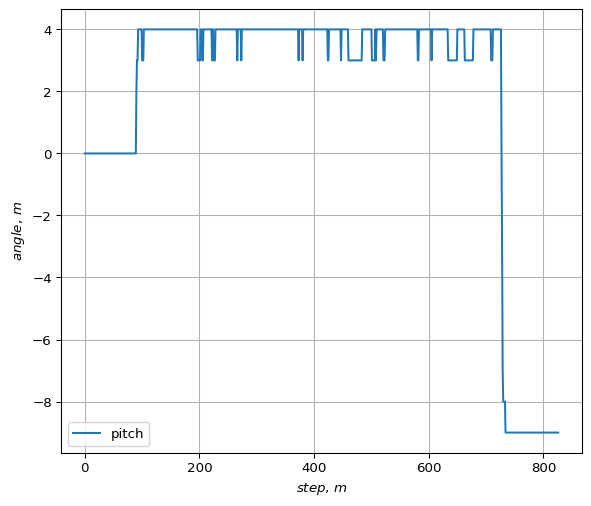

In [9]:
plt.figure('angle', figsize=(7, 6), dpi=96)
plt.plot(csv_tel.yaw, label="pitch")
plt.xlabel(r'$step,\, m$')
plt.ylabel(r'$angle,\, m$')
plt.legend()
plt.grid()

In [10]:
print(len(csv_telemetry.psi))

224


In [11]:
print(len(csv_camera.psi))

75


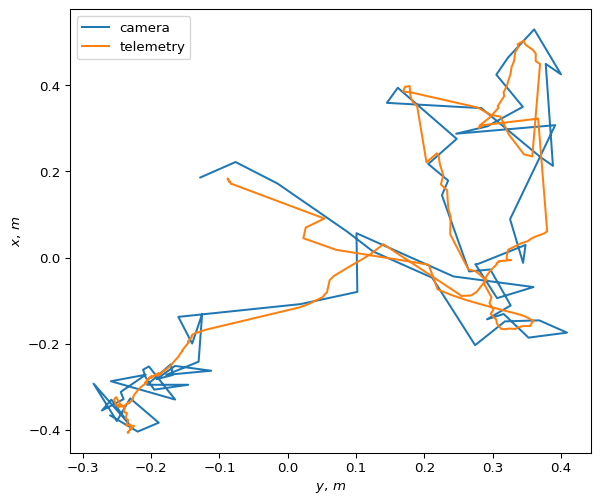

In [12]:
coord_diagrams(csv_camera, "camera")
coord_diagrams(csv_telemetry, "telemetry")

In [13]:
print(csv_telemetry.x.shape)

(224,)


In [14]:
def interpolate_to_single_x(points, n_points=200):
#     points = np.array([data.x, data.y]).T
    distance = np.cumsum(np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1)) )
    distance = np.insert(distance, 0, 0)/distance[-1]
    alpha = np.linspace(0, 1, n_points)

    interpolator =  interp1d(distance, points, kind='slinear', axis=0)
    interpolated_points = interpolator(alpha)
    return interpolated_points

In [15]:
interp_points = 224

In [16]:
# print([csv_camera.x, csv_camera.y], [csv_telemetry.x, csv_telemetry.y])

In [17]:
new_cam = interpolate_to_single_x(np.array([csv_camera.x, csv_camera.y]).T, interp_points)

In [26]:
new_telemetry = np.array([csv_telemetry.x, csv_telemetry.y, csv_telemetry.psi]) #interpolate_to_single_x(np.array([csv_telemetry.x, csv_telemetry.y]), interp_points)

In [27]:
print(new_cam.shape, new_telemetry.shape)

(3, 224) (3, 224)


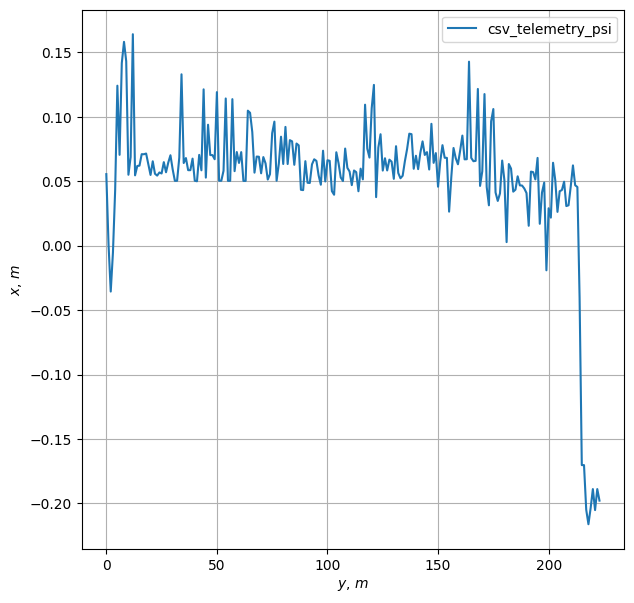

In [21]:
plt.figure(figsize=(7,7))
# plt.plot(csv_camera.psi, label="csv_camera_psi")
plt.plot(csv_telemetry.psi, label="csv_telemetry_psi")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

In [22]:
new_cam = new_cam.T
new_telemetry = new_telemetry.T

In [23]:
psitel = [csv_telemetry.psi.to_numpy()]

In [24]:
print(psitel, new_cam)

[array([ 0.05552343,  0.0011399 , -0.03561551, -0.00525361,  0.04308164,
        0.12416279,  0.07049171,  0.14173722,  0.1582002 ,  0.14314567,
        0.05503749,  0.06879037,  0.16411721,  0.05459126,  0.06183825,
        0.06212418,  0.07100703,  0.07095707,  0.0715049 ,  0.06321719,
        0.05487247,  0.06548017,  0.05580439,  0.05437248,  0.0568135 ,
        0.05601109,  0.06483249,  0.05696619,  0.06440581,  0.07018346,
        0.05928133,  0.05032288,  0.05034874,  0.06842113,  0.13299805,
        0.06413919,  0.06800277,  0.05860731,  0.0585896 ,  0.06755612,
        0.05039986,  0.04999419,  0.07045821,  0.05848896,  0.12133   ,
        0.05281722,  0.09387394,  0.07031529,  0.07028679,  0.06708044,
        0.1191746 ,  0.05038296,  0.05037596,  0.05811443,  0.11424247,
        0.05031481,  0.05029094,  0.11371962,  0.0578292 ,  0.07266384,
        0.06419565,  0.07260087,  0.05025895,  0.05024503,  0.10478761,
        0.10311157,  0.08820194,  0.05667714,  0.06916355,  0.0

In [25]:
new_cam = np.concatenate((new_cam, psitel), axis=0)
new_telemetry = np.concatenate((new_telemetry, psitel), axis=0)

In [28]:
print(new_cam.shape, new_telemetry.shape)

(3, 224) (3, 224)


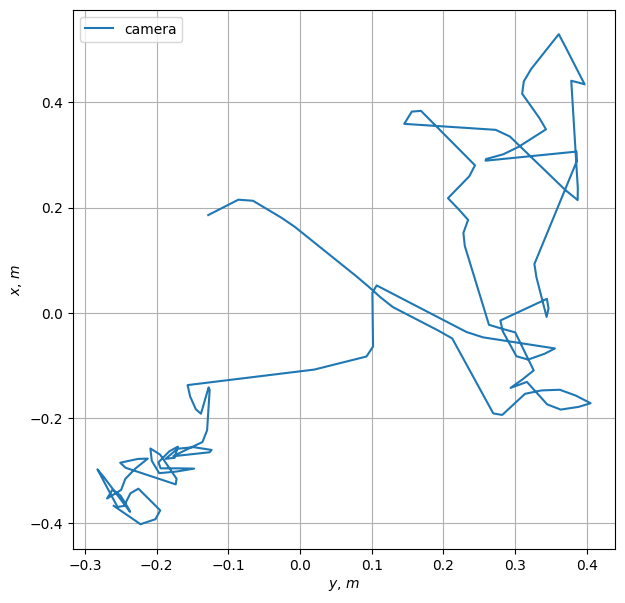

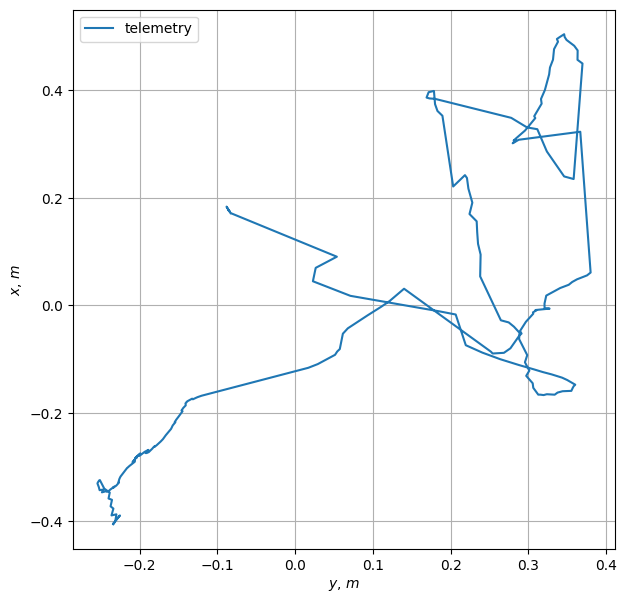

In [29]:
plt.figure(figsize=(7,7))
plt.plot(new_cam[0], new_cam[1], '-', label="camera")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

plt.figure(figsize=(7,7))
plt.plot(new_telemetry[0], new_telemetry[1], '-', label="telemetry")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

In [162]:
def get_commands(data):
    throttle = []
    rotation_speed = []
    for i in range(1, len(data[0])):
        x1, x2 = data[0][i], data[0][i-1]
        y1, y2 = data[1][i], data[1][i-1]
        psi1, psi2 = data[2][i], data[2][i-1]
        throttle.append(get_distance([x1, y1], [x2, y2]))
        dx = x1 - x2
        dy = y1 - y2
    #     rads = math.atan2(-dy,dx)
    #     rads %= 2*math.pi
        rads = wrap_to_pi(psi1 - psi2)
        degs = math.degrees(rads)
        rotation_speed.append(degs)

    throttle = np.array(throttle)
    rotation_speed = np.array(rotation_speed)
    print(throttle.shape, rotation_speed.shape)
    return throttle, rotation_speed

In [163]:
print(csv_tel.shape)

(5, 827)


In [188]:
throttle, rotation_speed = get_commands(new_telemetry)

(223,) (223,)


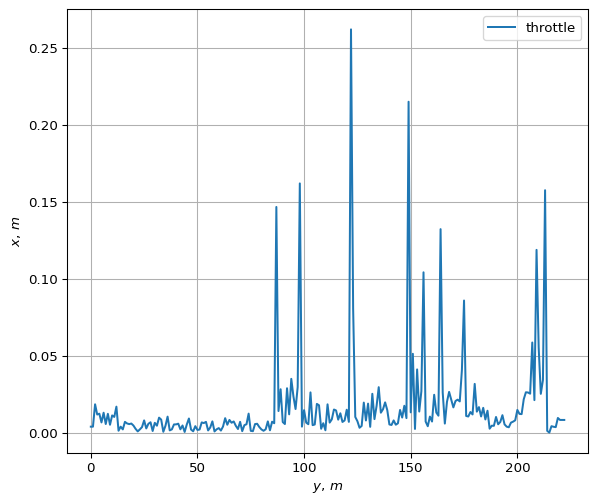

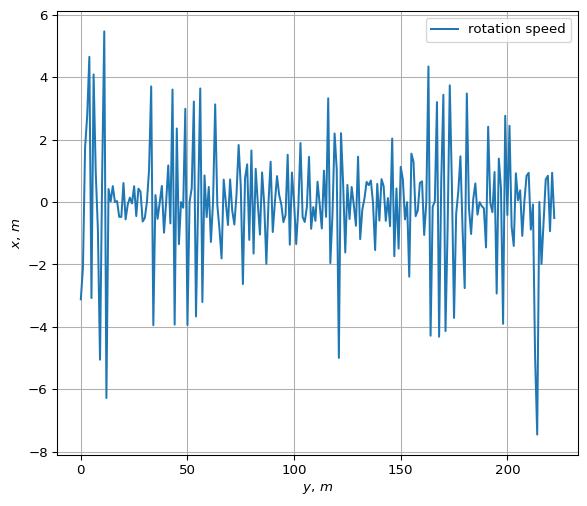

In [189]:
plt.figure('throttle', figsize=(7, 6), dpi=96)
plt.plot(throttle, '-', label="throttle")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

plt.figure('rotation command', figsize=(7, 6), dpi=96)
plt.plot(rotation_speed, label="rotation speed")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

In [223]:
def simulate(camera_coord, telemetry_coord, fault_range=None):
    kalman = Kalman((telemetry_coord[0][0], telemetry_coord[1][0], telemetry_coord[2][0]))
    navigation = Navigation(kalman)
    X_calculated = []
    for step in range(0, len(camera_coord[0])-1):
        
        if fault_range[0] > step or step > fault_range[1]:
            X_cam = (camera_coord[0][step], camera_coord[1][step], camera_coord[2][step])
        else:
            X_cam = (None, None, None)
        navigation.update_X_nav(X_cam, 40 * throttle[step], 0.2 * rotation_speed[step], DT)
        x, y, psi = navigation.get_X_nav()
        X_calculated.append([x, y, psi])
        
    return X_calculated  

In [224]:
DT = 0.004
X_calculated = np.array(simulate(new_cam, new_telemetry, [0, 0]))
print(X_calculated.shape)

X_calculated = np.transpose(X_calculated)
print(X_calculated.shape)

(223, 3)
(3, 223)


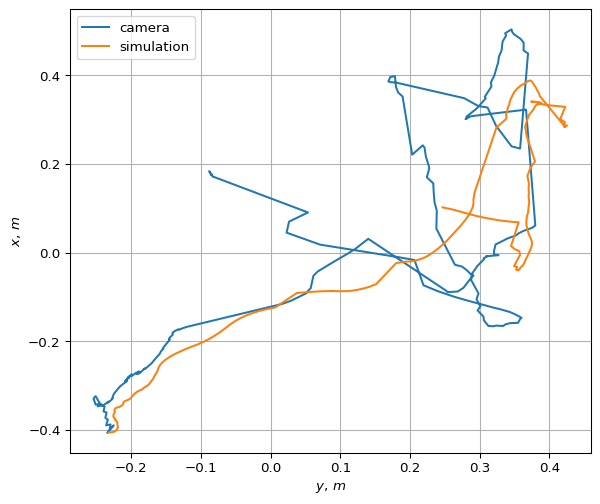

In [225]:
plt.figure('Coordinates', figsize=(7, 6), dpi=96)
plt.plot(new_telemetry[0], new_telemetry[1], '-', label="camera")
plt.plot(X_calculated[0], X_calculated[1], label="simulation")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()

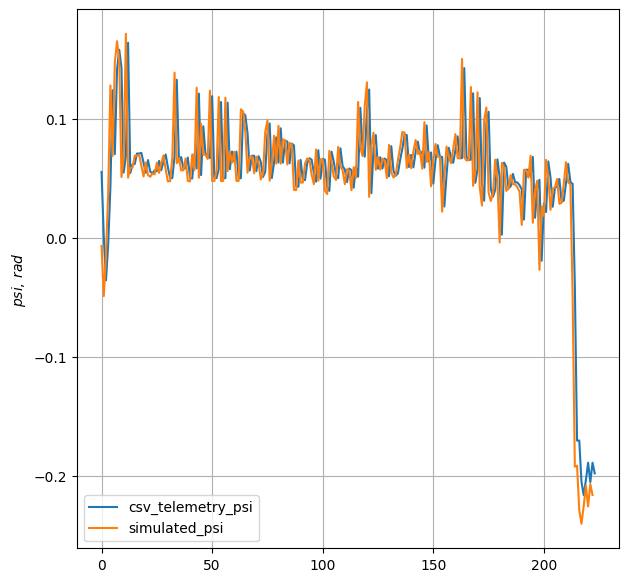

In [214]:
plt.figure(figsize=(7,7))
plt.plot(csv_telemetry.psi, label="csv_telemetry_psi")
plt.plot(X_calculated[2], label="simulated_psi")
plt.ylabel(r'$psi,\, rad$')
plt.legend()
plt.grid()

In [244]:
points = csv_telemetry.to_numpy()[:, :2]
theta = np.linspace(-3, 2, 40)
points = np.vstack( (np.cos(theta), np.sin(theta)) ).T

# add some noise:
points = csv_telemetry[:, :2] #points + 0.05*np.random.randn(*points.shape)

# Linear length along the line:
def interp_curve(points):
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=.002) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, 300)
    points_fitted = np.vstack( spl(alpha) for spl in splines ).T
    return points_fitted


points_fitted = interp_curve(points)
# Graph:
plt.plot(*points.T, 'ok', label='original points');
plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

InvalidIndexError: (slice(None, None, None), slice(None, 2, None))

In [255]:
points = np.array([csv_camera.x, csv_camera.y]).T

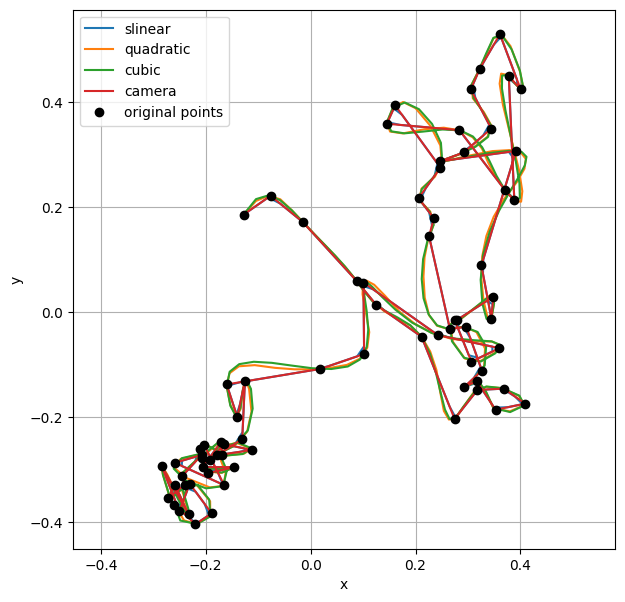

In [256]:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1)) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
interpolations_methods = ['slinear' , 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 200)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);
# plt.figure('Coordinates', figsize=(7, 6), dpi=96)
# plt.plot(X_calculated[1], X_calculated[0], label="Kalman")
plt.plot(csv_camera.x, csv_camera.y, label="camera")
# plt.plot(csv_telemetry.y, csv_telemetry.x, label="real")
plt.xlabel(r'$y,\, m$')
plt.ylabel(r'$x,\, m$')
plt.legend()
plt.grid()
    
plt.plot(*points.T, 'ok', label='original points');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');